# Electricity Demand Forecasting 

To ensure the better electric grid operation adn utility resourse planning, accurate electric energy demand forecasting is necessary. To enhance the grid resilience and energy security, the demand forecast should account for the extreme weather events also. As the world understood the need for utilising the natural energy sources, PV and solar grid installation also should be considered for accurate forecasting. 

In this project, first, a simple Linear Regression model is considered as a baseline model, and then the model is improved by considering multi seasonality and lag values of energy used. Final model uses XGBoost algorithm and the corresponding performance measures are: 

* R2 score = 0.99
* RMSE = 47.44
* MAPE = 1.44 %

This demonstrate an improvement of 0.33 in R2 score, a decrease of 6.8 % in MAPE, and a decrease of 207.54 in RMSE value,  from the baseline model. 

**Data Description:** *To develop the Electricity demand forecasting model, this project uses the Energy consumption data of SanDiego for the years 2014 to 2018, and the corresponding weather data from San Diego Airport weather station and PV installation data of SanDiego for the corresponding years is used.*

**Assumptions:** *This project is done by assuming that, the PV installation data and weather data are available in future, without any forecasting requirement. But in real time, it is required to forecast these also. However, simply subsituting the values for weather and PV installation related variables, using the already forecasted values will ensure the performance of the model developed in this work.* 


## Exploratory Data Analysis

* How does energy consumption vary across any particular day , averaged over the entire period??
* Monthly average load profile variations??
* Effect of temperature on energy consumption???
* Does the average monthly consumption values have increased over the years?
* how the energy consumption varies for weekdays vs the weekends or the holidays?
* Does increasing number of solar installations behind the customer meter resulted in a decrease in total energy consumption?


In [21]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

import warnings
warnings.filterwarnings('ignore')

In [22]:
df=pd.read_csv('energy_forecast_data.csv')

In [23]:
df.head(3)

,Unnamed: 0,Dates,SDGE,Date,year,month,day,hour,weekday,season,holiday,non_working,STATION,DailyCoolingDegreeDays,DailyHeatingDegreeDays,HourlyDryBulbTemperature,AC_kW,cum_AC_kW
0,0,2014-01-01 00:00:00,2096.0,2014-01-01,2014,1,1,0,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.0,0.0,220992.227
1,1,2014-01-01 01:00:00,1986.0,2014-01-01,2014,1,1,1,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.5,0.0,220992.227
2,2,2014-01-01 02:00:00,1936.0,2014-01-01,2014,1,1,2,Wednesday,winter,1,non-working,72290023188,0.0,7.0,51.8,0.0,220992.227


### Exploring the Energy Data

#### Average hourly energy consumption 

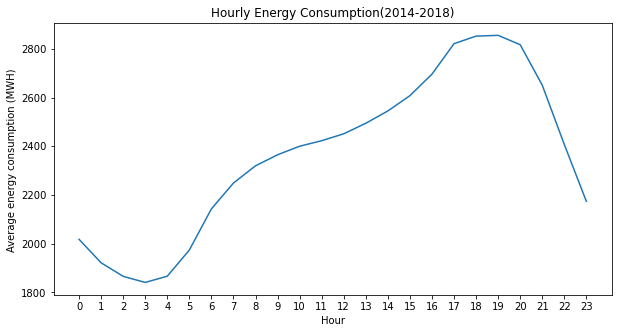

In [24]:
f1=df.groupby('hour')['SDGE'].mean().plot(figsize=(10,5))
plt.xlabel('Hour')
plt.ylabel('Average energy consumption (MWH) ')
plt.title('Hourly Energy Consumption(2014-2018)')
plt.xticks(df['hour'].unique())
plt.show()

Energy consumption peaks at evening. 04.00 PM to 8.00 PM is the interval that has high energy consumption.

#### Average monthly load profile 

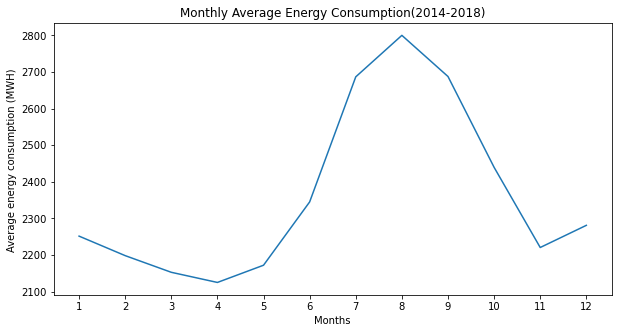

In [25]:
f1 = df.groupby('month')['SDGE'].mean().plot(figsize=(10,5))
plt.xlabel('Months')
plt.ylabel('Average energy consumption (MWH) ')
plt.title('Monthly Average Energy Consumption(2014-2018)')
plt.xticks(df['month'].unique())
plt.show()

Rapid increase in energy consumption from june and it attains peak value at August and then starts decreasing. June, July , august and september are the months which have higher consumption.

#### Monthly Trend

In [26]:
df_months = df.groupby(['month','year'])[['SDGE']].mean()
df_months = pd.DataFrame(df_months)
df_month=df_months.unstack(level='month').reset_index()
df_month.head(2)

year         SDGE                                                      \
month                  1            2            3            4            5   
0      2014  2289.122312  2287.229167  2237.892473  2256.341667  2435.094086   
1      2015  2255.966398  2205.293155  2258.916667  2196.484722  2146.177419   

                                                                        \
month            6            7            8            9           10   
0      2416.908333  2756.000000  2803.717742  2939.491667  2521.405914   
1      2412.219444  2578.725806  2848.950269  2955.175000  2656.813172   

                                 
month           11           12  
0      2231.704167  2308.564516  
1      2252.494444  2372.629032

In [27]:
melt_df = pd.melt(df_month, id_vars='year', value_name='Average monthly energy consumption in MWH')
melt_df.head()

,year,NaN,month,Average monthly energy consumption in MWH
0,2014,SDGE,1,2289.122312
1,2015,SDGE,1,2255.966398
2,2016,SDGE,1,2298.233871
3,2017,SDGE,1,2239.989221
4,2018,SDGE,1,2175.139451


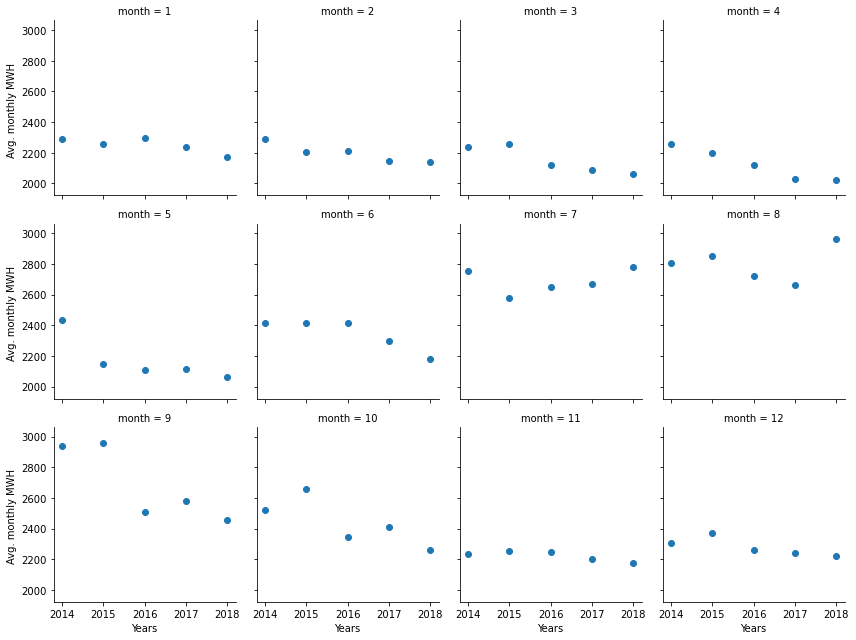

In [28]:
f2 = sns.FacetGrid(melt_df, col="month", margin_titles = True, col_wrap = 4)
f2.map(plt.scatter, "year", "Average monthly energy consumption in MWH");
f2.set_axis_labels("Years", "Avg. monthly MWH ");
f2.set(ylim=(melt_df['Average monthly energy consumption in MWH'].min() - 100, melt_df['Average monthly energy consumption in MWH'].max() + 100));

Average monthly Energy consumption decreases as the year passes, except for July and August

#### Weekly Trend
Average consumption for a particular hour over the week is considered.

In [29]:
#new pivot table , where index is hour and columns are the week days.
week_df = df.pivot_table(index='hour',columns='weekday',values='SDGE',aggfunc='mean')
#week_df

<AxesSubplot:xlabel='weekday', ylabel='hour'>

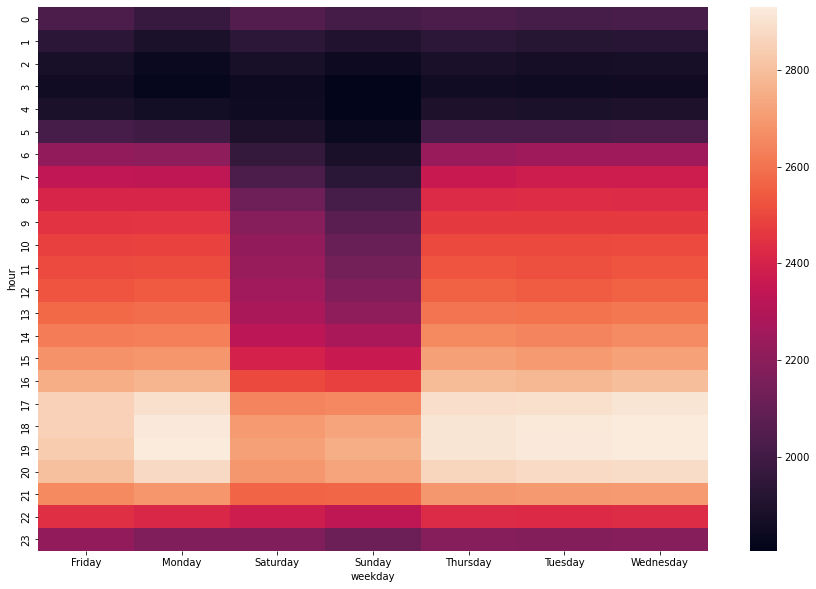

In [30]:
#plotting heatmap
f3 =plt.figure(figsize=(15,10))
sns.heatmap(week_df)

* Energy consumption is less on weekend days
* For all weekdays, energy consumption is high from 8 to 20, and it is peak at interval 17 to 20.

#### Overall Energy Consumption Distribution

Text(0.5, 1.0, 'Overall Energy Consumption Distribution (2014-2018)')

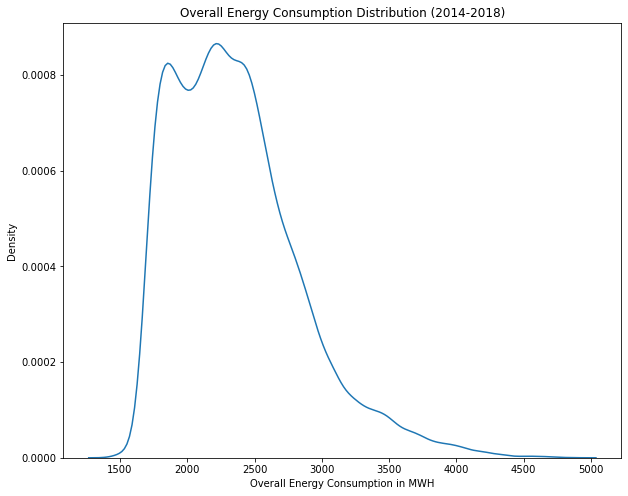

In [31]:
f4=plt.figure(figsize=(10,8))
sns.distplot(df['SDGE'],kde=True,hist=False)
plt.xlabel('Overall Energy Consumption in MWH')
plt.title('Overall Energy Consumption Distribution (2014-2018)')

Most of the days have an energy consumption of the range around 1700 - 2600 MWH

### Exploring Energy and Temperature data together

#### Temperature v/s Energy Consumption

Text(0.5, 1.0, 'Temperature vs Energy consumption')

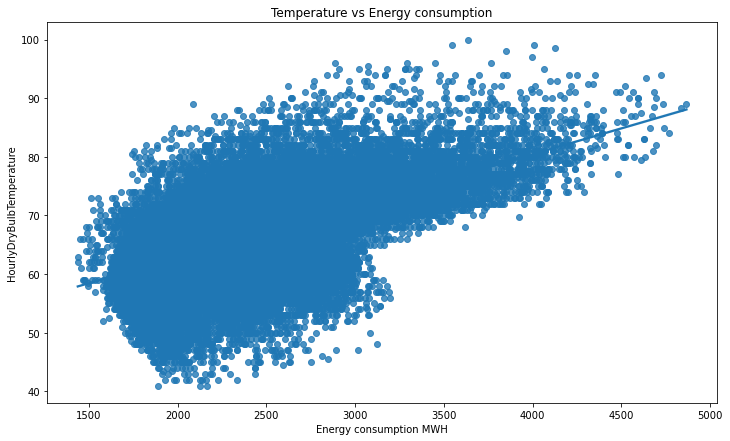

In [32]:
plt.figure(figsize=(12,7))
sns.regplot(x= 'SDGE', y= 'HourlyDryBulbTemperature' , data= df) # linear regression plot
plt.xlabel('Energy consumption MWH')
plt.title('Temperature vs Energy consumption')

#### Temperature v/s Energy Consumption for Summer 

Text(0.5, 1.0, 'Temperature vs Energy consumption for summmer')

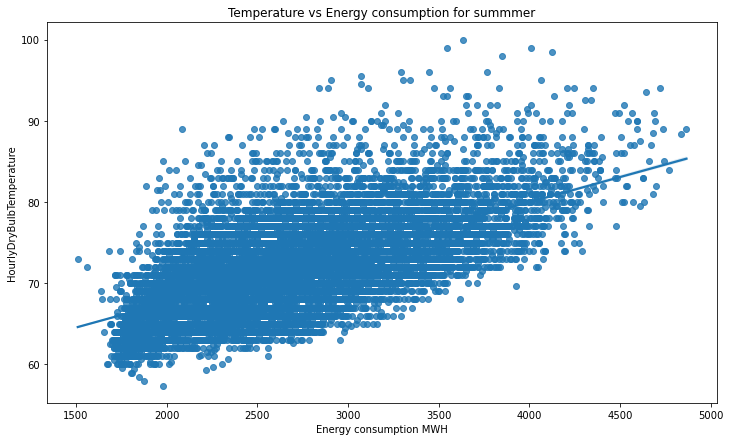

In [33]:
plt.figure(figsize=(12,7))
sns.regplot(x= 'SDGE', y= 'HourlyDryBulbTemperature' , data= df[df['season'] == 'summer' ]) 
plt.xlabel('Energy consumption MWH')
plt.title('Temperature vs Energy consumption for summmer')

#### Temperature v/s Energy Consumption for Winter

Text(0.5, 1.0, 'Temperature vs Energy consumption for winter')

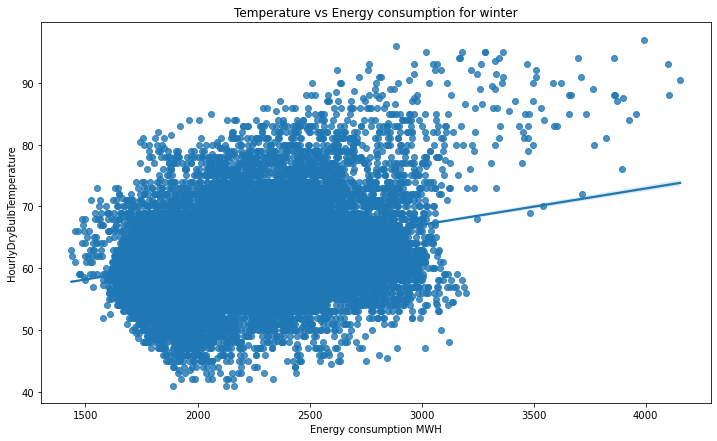

In [34]:
plt.figure(figsize=(12,7))
sns.regplot(x= 'SDGE', y= 'HourlyDryBulbTemperature' , data= df[df['season'] == 'winter' ]) 
plt.xlabel('Energy consumption MWH')
plt.title('Temperature vs Energy consumption for winter')

Energy consumption is more linearly varying with the temperature data in summer, comparing woth winter

### Exploring Energy and PV installation Data Together

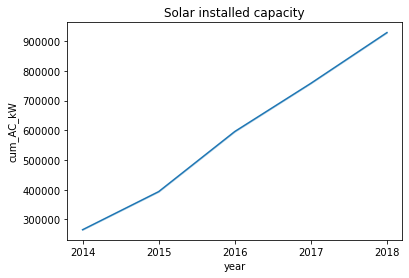

In [35]:
sns.lineplot(df['year'],df['cum_AC_kW'])
plt.title('Solar installed capacity')
plt.xticks(df['year'].unique())
plt.show()

In [36]:
daylight_hours = np.arange(10, 17) # 10 am to 5 pm is considered, as the sunlight available time
for season in df['season'].unique():
    corrcoef, pvalue = scipy.stats.pearsonr(df[(df['season'] == season) & (df['hour'].isin(daylight_hours))]\
                                            ['SDGE'],df[(df['season'] == season) & (df['hour'].isin(daylight_hours))]\
                                            ['cum_AC_kW'])
    print(' pearson correlation coefficient and pvalue for '+season, corrcoef, round(pvalue, 4))

 pearson correlation coefficient and pvalue for winter -0.46943200615703995 0.0
 pearson correlation coefficient and pvalue for summer -0.31540493662809566 0.0


***There is no much difference, because solar panles work more efficiently in colder temperature. As a whole, it is almost equal energy may be produced over winter and summer season, there will not be much difference.***